In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from hist_match import kernels, emulator
import math

plt.rcParams.update({'font.size': 14})

In [2]:
def true_model(x, y, c):
    return np.cos(np.sqrt(x**2 + 2*y**2)) + 1/3*x + c


In [3]:
def prepare_data(*args, n):
    
    # args = arrays of parameters
    # n = number of input dimensions
    # returns all combinations of input parameters
    
    return np.array(np.meshgrid(*args)).T.reshape(-1,n)

In [4]:
# create training set

N_y = 5    # number of points to sample
N_x = 5
N_c = 5

N_test = 30
x_train = np.linspace(-2, 2, N_x)
y_train = np.linspace(-2, 2, N_y)
c_train = np.linspace(-2, 2, N_c)
output_train = np.zeros((N_x*N_y*N_c))

input_train = prepare_data(x_train, y_train, c_train, n=3)



for i in range(input_train.shape[0]):
        output_train[i] = true_model(input_train[i,0], input_train[i,1], input_train[i,2])

# define entire parameter space
x_test = np.linspace(-2, 2, N_test)
y_test = np.linspace(-2, 2, N_test)
c_test = np.linspace(-2, 2, N_test)
input_test = prepare_data(x_test, y_test, c_test, n=3)
    

# for testing: true datapoints
true_x = 0.1
true_y = 0.2
true_c = -2
z = true_model(true_x, true_y, true_c) # observed datapoint
sigma_e = 0.1   # observational error
print(z)

-1.0113301775410606


In [5]:
# all training points (for plotting)
training_data = np.concatenate((input_train, output_train.reshape(-1, 1)), axis=1)

ValueError: too many values to unpack (expected 2)

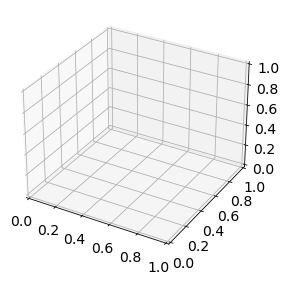

In [6]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')


X, Y = np.meshgrid(x_test, y_test, c_test)
Z = true_model(X,Y)

ax1.plot_surface(X, Y, Z, alpha=0.5)

ax1.scatter(true_x, true_y, z, color='red', label='Observed Data')
#ax.axhline(z-(3*sigma_e), linestyle='dashed', color='black', label='$\pm 3 \sigma_{e}$')
#ax.axhline(z+(3*sigma_e), linestyle='dashed', color='black')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('True Function')
ax1.legend(loc='best')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(training_data[:,0], training_data[:,1], training_data[:,2])
ax2.set_title('Training Data')
ax2.scatter(true_x, true_y, z, color='red', label='Observed Data')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')


In [7]:
# create squared-exponential kernel
d = 1              # no. of dimensions
sigma = 0.2        # sqrt variance of covariance function
theta = 0.8       # length scale
beta = 0           # prior expectation

def kernel(x1, x2, sigma, theta):
    # (norm of x1 - x2)^2 = norm x1 ^2 + norm x2 ^2 - 2 x1.x2   (ignore sqs as sqrt below)
    # norm of x1 = sqrt(x1_1 ^2 + x1_2^2 + ...)  (sum each column, equivalent to each input vector)
    
    # x1 is m x d array
    # x2 is n x d array
    # (m*n) combinations so want (m x n) covariance matrix eventually
    # norm(x1)(column vector) - norm(x2)(row vector) gives (m x n) array corresponding to each x1 and x2 combination
    # x1 dot x2.T gives equivalent (m x n) matrix of combinations
    
    
    if x1.ndim == 1:
        x1 = x1.reshape(-1, 1)
    if x2.ndim == 1:
        x2 = x2.reshape(-1, 1)
        
    
    norm_sq = np.sum(x1**2, axis=1).reshape(-1, 1) + np.sum(x2**2, axis=1)  - 2 * np.dot(x1, x2.T)
    K = sigma**2 * np.exp(- norm_sq / ((theta**2)))
    return K

In [8]:
# create posterior (using eqn 2.19 in Rasmussen)

def emulator(input_train, input_test, output_train, sigma, theta, beta):
    
    K_XX = kernel(input_train, input_train, sigma, theta)
    K_XsX = kernel(input_test, input_train, sigma, theta)
    K_XXs = kernel(input_train, input_test, sigma, theta)
    K_XsXs = kernel(input_test, input_test, sigma, theta)
    K_XX_inv = np.linalg.inv(K_XX)
    
    mu = beta + K_XsX.dot(K_XX_inv).dot(output_train - beta)
    cov = K_XsXs - K_XsX.dot(K_XX_inv).dot(K_XXs)
    
    # put abs for now but SHOULD NOT BE NEGATIVE!!!!
    sd = np.sqrt(np.abs(np.diag(cov)))
    
    return mu, cov, sd

In [9]:
mu, cov, sd = emulator(input_train, input_test, output_train, sigma, theta, beta)
sd2 = sd.reshape(N_test,N_test,N_test)
mu_matrix = mu.reshape(N_test,N_test,N_test)

KeyboardInterrupt: 

In [ ]:
print(sd.shape)

In [ ]:

X2, Y2 = np.meshgrid(x_test, y_test)

fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot_surface(X2, Y2, Z, alpha=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('True Function')
ax1.scatter(true_x, true_y, z, color='red', label='Observed Data')

#ax2.plot_surface(X2, Y2, mu_matrix, alpha=0.5)
ax2.scatter(input_test[:,0], input_test[:,1], mu_matrix.flatten(), s=1)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('Emulator Model')
ax1.scatter(true_x, true_y, z, color='red', label='Observed Data')

ax3.plot(y_test, mu_matrix[:,0])
ax3.set_xlabel('y')
ax3.set_ylabel('z')
ax3.set_title('Emulator Model (x=-5)')

ax3.fill_between(y_test, mu_matrix[:,0] + 3*sd2[:,0], mu_matrix[:,0] - 3*sd2[:,0], alpha=0.2, color='orange')



In [10]:
# define implausibility measure

def implausibility(E, z, var, var_md, var_obs):
    
    # E - emulator expectation
    # z - observational data
    # var - credible interval
    # var_md - model discrepency error
    # var_obs - observational error
    
    return np.sqrt( ( E - z )**2  /  ( var + var_md + var_obs ) )

In [11]:
p = 0
ar = np.zeros((3,3,3))
for i in range(3):
    for j in range(3):
        for k in range(3):
            ar[i,j,k] = p + i + k + j
            
print(ar)

[[[0. 1. 2.]
  [1. 2. 3.]
  [2. 3. 4.]]

 [[1. 2. 3.]
  [2. 3. 4.]
  [3. 4. 5.]]

 [[2. 3. 4.]
  [3. 4. 5.]
  [4. 5. 6.]]]


In [12]:
# evaluate implausibility over parameter space
implaus = np.zeros((N_test,N_test,N_test))
for i in range(N_test):
    for j in range(N_test):
        for k in range(N_test):
            implaus[i,j,k] = implausibility(mu_matrix[i,j,k], z, sd2[i,j,k], 0, sigma_e**2)

NameError: name 'mu_matrix' is not defined

In [ ]:
X, Y = np.meshgrid(x_test, y_test)
fig, ax = plt.subplots()
im = ax.contourf(X, Y, implaus[:,:,0], 20, cmap='viridis_r')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Implausibility')
plt.ylabel('y')
plt.xlabel('x')
ax.scatter(true_x, true_y, color='red', label='Observed Data')
ax.legend(loc='lower left')

In [17]:
def history_match(input_train, input_test, output_train, sigma, theta, beta, dim, waves=1):
    
    N_test = 30
    #N_training_pts = len(input_train)    # initial number of training points
    N_test_pts = len(input_test)         # initial number of test points
    #print(N_test_pts)
    
    # prepare data by finding all combinations of inputs
    #input_train = prepare_data(x_train, y_train, n=dim)
    #input_test = prepare_data(x_test, y_test, n=dim)
    #output_train = z_train.flatten()
    
    
    # find initial test data range (for plotting)
    test_min = np.amin(input_train, axis=0)
    test_max = np.amax(input_train, axis=0)
    
    # plot settings
    fig, axes = plt.subplots(waves, 2, figsize=(14, 6*waves))
    ax_list = fig.axes
    
    for k in range(waves):
        
        print('Current wave: ' + str(k+1))
        
        # fit emulator using training points
        print('Fitting Emulator...')
        mu, cov, sd = emulator(input_train, input_test, output_train, sigma, theta, beta)
        #sd = sd.reshape((N_test_pts, N_test_pts))
        #mu = mu.reshape((N_test_pts, N_test_pts))
        
        # evaluate implausibility over parameter space
        print('Evaluating implausibility...')
        implaus = np.zeros(len(input_test))
        for i in range(len(input_test)):
                implaus[i] = implausibility(mu[i], z, sd[i], 0, sigma_e**2)
                
        
        
        # plot implausibilities
        #ax1 = ax_list[2*k]
        #ax2 = ax_list[2*k + 1]
        #X, Y = np.meshgrid(x_test, y_test)
        #im = ax1.contourf(X.T, Y.T, implaus[], 30, cmap='viridis_r')
        #ax1.set_facecolor((68/255,1/255,84/255))
        #ax1.set_xlim([xmin_0, xmax_0])
        #ax1.set_ylim([ymin_0, ymax_0])
        #cbar = fig.colorbar(im, ax=ax1)
        #cbar.set_label('Implausibility')
        #im.set_clim(0,10)
        #ax1.set_ylabel('y')
        #ax1.set_xlabel('x')
        #ax1.set_title('Wave ' + str(k+1) + ' Implausibility')
        #ax1.scatter(true_x, true_y, color='red', marker='x', label='Observed Data')
        
        # identify implausible region
        data = np.concatenate((input_test, implaus.reshape(-1,1)), axis=1)
        nonimplausible = np.delete(data, np.where(data[:,-1] > 3.5)[0], axis=0)
        
        
        # find nonimplausible boundaries
        implaus_min = np.amin(nonimplausible[:,:dim], axis=0)
        implaus_max = np.amax(nonimplausible[:,:dim], axis=0)
        
        # redefine nonimplausible space
        inputs = np.zeros((N_test, dim))
        for i in range(dim):
            inputs[:,0] = np.linspace(implaus_min[i], implaus_max[i], N_test)
            
        #x_test = np.linspace(xmin, xmax, N_test_pts)
        #y_test = np.linspace(ymin, ymax, N_test_pts)
        input_test = prepare_data(*inputs.T, n=dim)
        
        # generate new training points
        #X1 = xmin + ( (xmax - xmin)/3 )
        #X2 = xmax - ( (xmax - xmin)/3 )
        #Y1 = ymin + ( (ymax - ymin)/3 )
        #Y2 = ymax - ( (ymax - ymin)/3 )
        #N_training_pts += 2
        #x_train = np.append(x_train, [X1,X2])
        #y_train = np.append(y_train, [Y1,Y2])
        #input_train = prepare_data(x_train, y_train, n=dim)
        
        # evaluate model over training data
        # **** this is inefficient as redoing all training points ****
        #z_train = np.zeros((N_training_pts,N_training_pts))
        #for i in range(N_training_pts):
            #for j in range(N_training_pts):
                #z_train[i,j] = true_model(x_train[i], y_train[j])
        #output_train = z_train.flatten()'''
        
        # plot nonimplausible datapoints
        #ax2.scatter(nonimplausible[:,0], nonimplausible[:,1], nonimplausible[:,-1])
        #ax2.scatter(true_x, true_y, color='red', marker='x', label='Observed Data')
        #ax2.set_title('Remaining Non-Implausible Datapoints')
        #ax2.scatter(x_train, y_train, color='lightgreen', label='Training Data')
        #ax2.legend(loc='lower left')

Current wave: 1
Fitting Emulator...
Evaluating implausibility...


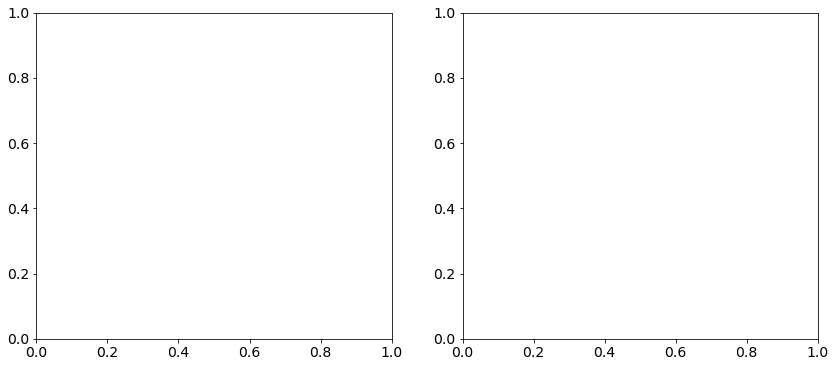

In [18]:
history_match(input_train, input_test, output_train, sigma, theta, beta, 3, 1)